In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [3]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')
# do NOT push this into my github!  sub in last minute when i actually run this in jupyter!

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [7]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

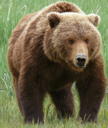

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))
        
        # After this, should see bears/ folder on left panel and images therein

In [11]:
fns = get_image_files(path)
fns

(#433) [Path('bears/black/00000100.jpg'),Path('bears/black/00000146.jpg'),Path('bears/black/00000073.jpg'),Path('bears/black/00000008.jpeg'),Path('bears/black/00000035.jpg'),Path('bears/black/00000061.jpg'),Path('bears/black/00000078.jpg'),Path('bears/black/00000055.jpg'),Path('bears/black/00000068.jpg'),Path('bears/black/00000053.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#4) [Path('bears/black/00000110.jpg'),Path('bears/black/00000097.jpg'),Path('bears/teddy/00000103.png'),Path('bears/teddy/00000070.jpg')]

In [13]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [ ]:
DataLoaders is a thin class that just stores whatever DataLoader objects you pass to it, 
and makes them available as train and valid. 
It provides the data for your model. 
The key functionality in DataLoaders is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
    
To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:
 - What kinds of data we are working with
 - How to get the list of items
 - How to label these items
 - How to create the validation set
DataBlock API lets u customize every stage of the creation of your DataLoaders.  As seen in cell below.                                                                                     
                                                                                     


In [14]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,  
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label,
    item_tfms=Resize(128))
# ImageBlock is the independent variable (=x), CategoryBlock is dependent (=y)
# get_image_files takes a path and returns list of all imgs there
# if training/validation sets are not split already, RandomSplitter can do it!  same seed value lets u split the same way each run.
# get_y=parent_label tells fastai that the labels for the training & validation sets are the parent_label which is the name of the folder those imgs are in
# item_tfms, resize is needed bc we send data in an array batch (called a tensor) to the model, which req the same size/dimension
    # remember the padding of words seen in Huggingface tutorials?

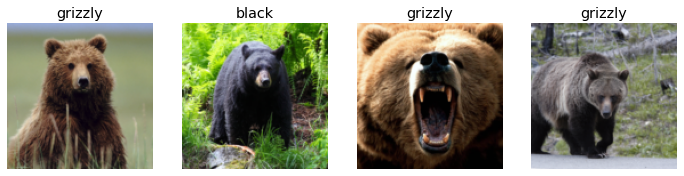

In [15]:
# default is to show as square crops, but stuff can get cut out, like tops of ears on 1st teddy
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
# Look at how we used dataBlockInstance.new() to reuse the params when we made the new DataBlock instance of bears!

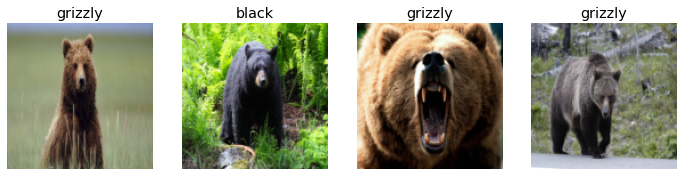

In [16]:
# let's resize it via squish
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))

dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

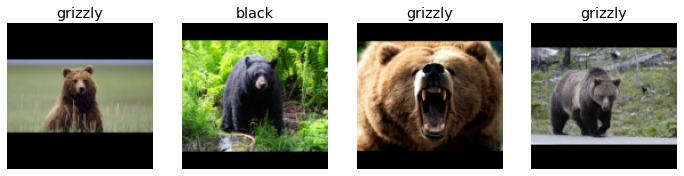

In [17]:
# or we can pad out empty space with 0/black
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))

dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

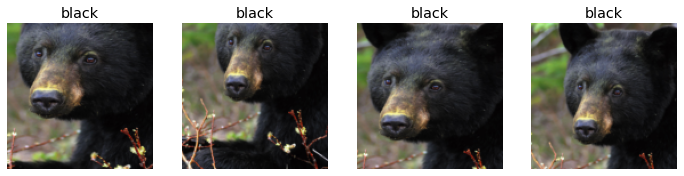

In [18]:
# or we can do a random resize crop
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


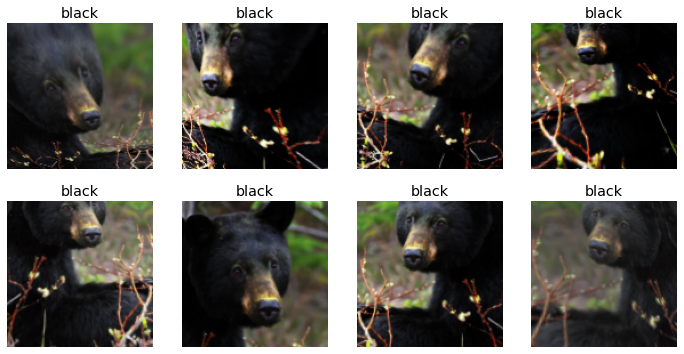

In [19]:
# Data Augmentation w/ rotating, flipping, warping, changing color/brightness/contrast, etc
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))

dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [20]:
#  Now we combine both random resize crops AND funky data augmentations from the 2 above!
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = bears.dataloaders(path)

In [ ]:
### Back to the pattern established in Wk1, now we want to run 
### STEP 3: xyz_learner & STEP 4: learn.fine_tune/fit on it
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

### ANALYZE via train_loss, valid_loss, & error_rate printout

epoch,train_loss,valid_loss,error_rate,time
0,1.521585,0.090799,0.023529,01:08


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
### ANALYZE via confusion matrix.  color coded.

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
### ANALYZE via top losses
    # Here I got black/black/0.14/0.98 <-- even my worst loss is correctly predicted, yay.

interp.plot_top_losses(5, nrows=1)

In [ ]:
### CLEAN images via a GUI
    # lets u MANUALLY look thru training/validation sets and delete or re-categorize them
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# Run this to solidify changes made via cleaner GUI above
print(cleaner.delete())
print(cleaner.change())
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
### SAVE/EXPORT THE MODEL!  Both the architecture & the parameters!
   # export() will save both
   # this will gen an export.pkl file, see left panel or ls

learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
### LOAD LEARNER
# When using a model for real predictions, it's called INFERENCE.  
    # pretend our learner is not in this notebook above already, and that we're grabbing it from this .pkl file

learn_inf = load_learner(path/'export.pkl')

In [ ]:
### INFERENCE/PREDICT
    # try it on this 1 picture we got earlier.  This is acting as the "testing set" now.
learn_inf.predict('images/grizzly.jpg')

In [ ]:
# This is the categories for which the probabilities in the TensorBase in above prediction is assoc'd with
learn_inf.dls.vocab

### Creating a Notebook App from the Model

In [ ]:
# First, we need a file upload widget

btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
# Show the image
   # Try running this both with the grizzly.jpg above and manually upload Butters/Oski

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

# Here we'll see Butters/Oski are classified as teddy bears lol


In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
# Put all 4 components together in a Vertical Box to make a GUI 
    # which lets u upload pics & classify altogether!!! <3

VBox([widgets.Label('LOOK AT DAT BEAR!!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
### DEPLOY !!!!  Go see BearApp.ipynb!!!

# copy & paste below into a NEW file... BearApp.ipynb
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.